__оценка схожести изображений с помощью сиамской нейросети__

Евгений Борисов <esborisov@sevsu.ru>

---

Jane Bromley, Isabelle Guyon, Yann LeCun, Eduard Sickinger and Roopak Shah     
Signature Verification using a "Siamese" Time Delay Neural Network.    1994       
AT&T Bell Laboratories  
https://papers.nips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf

Gregory Koch  Siamese Neural Networks for One-Shot Image Recognition.  2015    
http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf    

Николай Князев  Распознавание лиц с помощью сиамских сетей. 2019    
https://habr.com/ru/company/jetinfosystems/blog/465279/

Владислав Виноградов  Как построить свою систему поиска похожих изображений.  2021  
https://habr.com/ru/post/550604/

In [1]:
# from os.path import join as pjoin
# from os import listdir
from itertools import combinations
import numpy as np
import numpy.random as rng
# import gzip
# import idx2numpy
from matplotlib import pyplot as plt

## загружаем учебный набор

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(image_train, target_train),(image_test, target_test) = fashion_mnist.load_data()
image_train.shape, image_test.shape

((60000, 28, 28), (10000, 28, 28))

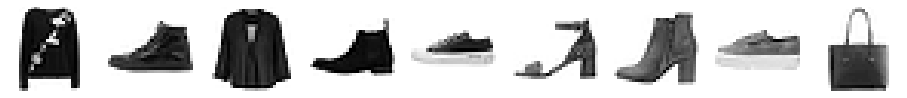

In [3]:
n_show = 9

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
    img = image_train[i]
    plt.subplot(1,n_show,n)
    plt.axis(False)
    plt.imshow(img,cmap='gray_r')

## строим учебный датасет

соберём два набора пар - похожие и непохожие картинки;

похожие пары собираем из одного класса, непохожие из разных классов

In [4]:
# позитивные примеры - пары одного класса
def sample_pos_class(x,y,c):
    xc = x[y==c] # выбираем примеры класса с
    ii = rng.permutation(xc.shape[0]) # индексы примеров в случайном порядке
    return xc[ii],xc 

def sample_pos(x,y):
    x_left,x_right = [],[]
    for c in set(y):
        xl,xr = sample_pos_class(x,y,c)
        x_left.append(xl)
        x_right.append(xr)
    return np.vstack(x_left),np.vstack(x_right)

In [5]:
# негативные примеры - пары разных классов

# размножить примеры класса
def reproduce_samples(x,dn):
    n = x.shape[0] 
    i = rng.permutation(n)[:dn]
    return np.vstack([x,x[i,:]])

def sample_neg_class(x,y,c0,c1):
    assert c0!=c1
    xc0 = x[y==c0] # выбираем примеры класса с0
    xc1 = x[y==c1] # выбираем примеры класса с1
    
    n0 = xc0.shape[0] # количество примеров класса с0
    n1 = xc1.shape[0] # количество примеров класса с1
    
    # выравниваем количества примеров в классах
    if n0>n1: # в классе с1 меньше примеров
        xc1 = reproduce_samples(xc1,n0-n1)
        n1=xc1.shape[0]
        
    if n0<n1: # в классе с0 меньше примеров
        xc0 = reproduce_samples(xc0,n1-n0)
        n0=xc0.shape[0]

    # индексы примеров в случайном порядке
    i0 = rng.permutation(n0) 
    i1 = rng.permutation(n1) 

    return xc0[i0,:],xc1[i1,:] 
    
# xl,xr = sample_neg_class(x_train,y_train,2,3)


def sample_neg(x,y,p=-1):
    cc = set(y) # список классов
    
    # все комбинации разных классов
    cc = list(combinations(cc,2))
    
    
    # ограничиваем количество пар
    if p>0: cc = rng.permutation(cc)[:p]

    x_left,x_right = [],[]
    for c0,c1 in cc:
        xl,xr = sample_neg_class(x,y,c0,c1)
        x_left.append(xl)
        x_right.append(xr) 
        
    return np.vstack(x_left),np.vstack(x_right)    

In [6]:
# картинки похожие, позитивные примеры
x_left_p, x_right_p = sample_pos(image_train,target_train)
target_p = np.ones((x_left_p.shape[0],1),dtype=np.float32)

x_left_p.shape, x_right_p.shape, target_p.shape  

((60000, 28, 28), (60000, 28, 28), (60000, 1))

In [7]:
# картинки не похожие негативные примеры
x_left_n,x_right_n = sample_neg(image_train,target_train)
target_n = np.zeros((x_left_n.shape[0],1),dtype=np.float32)

x_left_n.shape, x_right_n.shape, target_n.shape     

((270000, 28, 28), (270000, 28, 28), (270000, 1))

In [8]:
x_left_train  = np.vstack([x_left_n,  x_left_p])
x_right_train = np.vstack([x_right_n, x_right_p])
target_train  = np.vstack([target_n, target_p])

x_left_train.shape, x_right_train.shape, target_train.shape

((330000, 28, 28), (330000, 28, 28), (330000, 1))

In [9]:
def shuffle_dataset(x_left, x_right, target):
    ii = rng.permutation(x_left.shape[0])
    return x_left[ii,:],x_right[ii,:],target[ii,:]

In [10]:
target_train

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

## строим модель

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Lambda

# from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# from tensorflow_addons.losses import contrastive_loss
# from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.utils import plot_model

In [ ]:
print('tensorflow',tf.__version__)
print('keras',tf.keras.__version__)

In [ ]:
# два входа модели
input_shape = image_train.shape[1:] + (1,)
# regularizer_rate = 2e-4
left_input, right_input = Input(input_shape), Input(input_shape)

In [ ]:
# модель (свёрточная сеть) извлекающая признаки из картинок
encoder = Sequential(name='encoder')
encoder.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape)) 
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
encoder.add(Conv2D(128,(3,3),activation='relu')) 
encoder.add(Flatten())
encoder.add(Dense(512, activation='sigmoid'))

In [ ]:
encoded_l = encoder(left_input) # левая ветка
encoded_r = encoder(right_input) # правая ветка

# считаем расстояние L1
L1_distance = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([encoded_l,encoded_r])
prediction = Dense(1,activation='sigmoid',)(L1_distance)

# собираем части в одну модель
model = Model(inputs=[left_input,right_input],outputs=prediction)

In [ ]:
# model.summary()
plot_model(model, show_layer_names=True, show_shapes=True )

## обучаем модель

функция потери
$$
contrastive\_loss(y,p) = y \cdot p^2 + (1 - y) \cdot \max(0, m - p ) ^2
$$

y - метка (1-похоже,0-непохоже);   
p - оценка модели;    
m - margin, минимально допустимое растояние между непохожими

In [ ]:
# from tensorflow_addons.losses import contrastive_loss

def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    return K.mean( y * K.square(preds) + (1-y)*squaredMargin)

In [ ]:
x_left_train.shape, x_right_train.shape, target_train.shape

In [ ]:
# дополнительно перемешиваем датасет
x_left_train,x_right_train,target_train = shuffle_dataset(x_left_train,x_right_train,target_train)

In [ ]:
%%time

# обучаем модель

model.compile(loss=contrastive_loss,optimizer=Adam(learning_rate=1e-5) )

history = model.fit( 
    [x_left_train, x_right_train], 
    target_train,
    epochs=5,
    batch_size=512,
)


In [ ]:
plt.plot(history.history['loss'],label='train loss')
# plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

## тестируем

In [ ]:
# формируем похожие и непохожие пары картинок

x_left_p, x_right_p = sample_pos(image_test,target_test)
x_left_n,x_right_n = sample_neg(image_test,target_test)

x_left_test  = np.vstack([x_left_n,  x_left_p])
x_right_test = np.vstack([x_right_n, x_right_p])

x_left_test.shape, x_right_test.shape, # target_test.shape

---

In [ ]:
# меряем расстояния на тестовых парах
p = model.predict([x_left_test,x_right_test])
p.shape

In [ ]:
n_show = 10
cmap='gray_r'

# близкие картинки
ii = np.where(p.flatten()<.25)[0]
ii = rng.permutation(ii[:n_show])
fig,ax = plt.subplots(2,n_show,figsize=(16,4))
for n,i in enumerate(ii):
    imgL = x_left_test[i,:]
    imgR = x_right_test[i,:]
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    

# p[ii]    

In [ ]:
# далёкие картинки

ii = np.where(p.flatten()>.2)[0]
ii = rng.permutation(ii[:n_show])
fig,ax = plt.subplots(2,n_show,figsize=(16,4))
for n,i in enumerate(ii):
    imgL = x_left_test[i,:]
    imgR = x_right_test[i,:]
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    